# Círculo de Mohr y círculo de tracciones

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook puede ejecutarse en línea → [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/mohr_circles.ipynb) 

Visualización del círculo de tracciones gracias al paquete **continuum_mechanics** V0.2.2 [(Guarín-Zapata et al.,2021)](https://doi.org/10.5281/zenodo.4682112)

## Módulos requeridos y configuración global de figuras

In [1]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install continuum_mechanics', shell=True);
    # run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()
    
from continuum_mechanics.visualization import mohr2d, mohr3d, traction_circle

# %matplotlib widget
plt.style.use('default')
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

**Centro, $c$, y esfuerzo medio, $\sigma_\mathrm{m}$**
$$
c = \sigma_\mathrm{m} = \frac{1}{2} (\sigma_\mathrm{xx} + \sigma_\mathrm{yy})
$$

**Radio, $r$ y esfuerzo cortante máximo, $\tau_\mathrm{max}$**

$$
r = \tau_\mathrm{max} = \sqrt{\tau_\mathrm{xy} + (\sigma_\mathrm{xx}^2 - c)^2}
$$

## Funciones

In [2]:
def plot_mohr_circle(
    sigma_xx, sigma_yy, tau_xy, plot_envelope=False, envelope={'c': 5, '𝜙': 27},
    plot_pole=False, plot_plane=False, alpha=0, xlim=None, ylim=None, **kwargs
):
    if type(envelope) == str:  # This is for interpreting in from the widget
        envelope = ast.literal_eval('{' + envelope + '}')

    c = 0.5 * (sigma_xx + sigma_yy)
    r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
    sig_1 = r * np.cos(0) + c
    sig_3 = r * np.cos(np.pi) + c

    outcome = {
        "sig_1": sig_1,
        "sig_3": sig_3,
        "sig_xx": sigma_xx,
        "sig_yy": sigma_yy,
        "tau_xy": tau_xy,
        "s": 0.5 * (sig_1 + sig_3),
        "t": 0.5 * (sig_1 - sig_3),
        "p": 1 / 3 * (sig_1 + 2 * sig_3),
        "q": sig_1 - sig_3,
    }

    theta = np.linspace(0, 2 * np.pi, 200)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=kwargs.get('figsize'))#[7, 4.5])
    ax.axhline(y=0, c="k")
    ax.plot(r * np.cos(theta) + c, r * np.sin(theta), c="k")  # Mohr circle

    label = "$\sigma_{1}=$" + f"{sig_1:.1f}"  # sigma_1
    ax.plot(sig_1, 0, ls="", c="#BB5566", marker=".", ms=12, label=label)
    label = "$\sigma_{3}=$" + f"{sig_3:.1f}"  # sigma_3
    ax.plot(sig_3, 0, ls="", c="#004488", marker=".", ms=12, label=label)
    # Mean stress
    ax.plot(c, 0, ls="", c="k", marker="o", label="$\sigma_\mathrm{m}=$" + f"{c:.1f}")
    label = "$\\tau_\mathrm{max}=$" + f"{r:.1f}"  # tau_max
    ax.plot(c, r, ls="", c="orchid", marker="o", ms=7, label=label)
    # sigma_xx, tau_xy
    label = ("$\sigma_{xx}=$" + f"{sigma_xx:.1f}" + ",\n$\\tau_{xy}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_xx, tau_xy, ls="", c="#DDAA33", marker="s", label=label)
    # sigma_yy, (-)tau_xy
    label = ("$\sigma_{yy}=$" + f"{sigma_yy:.1f}" + ",\n$\\tau_{yx}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_yy, -1 * tau_xy, ls="", c="#117733", marker="s", label=label)

    pole = (sigma_xx, -1 * tau_xy)
    if plot_pole:  # Pole and stress on a plane
        ax.axhline(y=pole[1], c="k", ls="--", lw=0.75)
        ax.axvline(x=pole[0], c="k", ls="--", lw=0.75)
        ax.plot(*pole, ls="", c="k", marker="o", fillstyle='none', label=f"Pole: {pole}")
    if  plot_plane:
        # beta = 0.5 * np.degrees(np.arctan(tau_xy/sigma_xx))
        # beta = np.degrees(np.arctan((sig_1 - sigma_xx)/tau_xy))
        beta = 0.5 * np.degrees(np.arctan2(2 * tau_xy, sigma_xx - sigma_yy))
        theta = alpha + beta
        plane_sig_n = r * np.cos(np.radians(2 * theta)) + c
        plane_tau_n = r * np.sin(np.radians(2 * theta))
        label = (
            "Stress state on the plane\n" + "$\sigma_\mathrm{n}=$" + f"{plane_sig_n:.1f}"
            + ", $\\tau_\mathrm{n}=$" + f"{plane_tau_n:.1f}"
        )
        ax.plot(plane_sig_n, plane_tau_n, ls="", c="r", marker=".", label=label)
        ax.plot(
            (plane_sig_n, pole[0]), (plane_tau_n, pole[1]), c="r", ls="--",
            lw=0.75, label=f"Plane at {alpha:.1f}" + "$^{\circ}\circlearrowleft$ from $y^{(+)}$"
        )
        ax.plot(
            (plane_sig_n, c), (plane_tau_n, 0), c="b", ls="--",
            lw=0.75, label="2$\\theta=$" + f"{theta:.1f}" + "$^{\circ}$"
        )

    if plot_envelope:  # Failure envelope
        tan_𝜙 = np.tan(np.radians(envelope['𝜙']))
        c_env = envelope['c']
        label = ("Failure criterion \n $\\tau_\mathrm{n} = "+ f"{c_env} + "
                 + "\\tan" + f"{envelope['𝜙']}^\circ" + "\sigma_\mathrm{n}$")
        # ax.axline(xy1=(0, c_env), slope=np.tan(𝜙_r), c="r", label=label)
        xlim = ax.get_xlim() if xlim is None else xlim
        ylim = ax.get_ylim() if ylim is None else ylim
        x_env = np.array([-9e9, 9e9])
        ax.plot(x_env, tan_𝜙 * x_env + c_env, c="r", label=label)

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines[["bottom","left"]].set_linewidth(1.5)
    ax.tick_params(width=1.5)
    # # ax.axis("equal")
    # ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set_aspect("equal", anchor=None)
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}$",
        ylabel="Shear stress, $\\tau_\mathrm{n}$",
        xlim=xlim,
        ylim=ylim
    )
    plt.show()
    return outcome

def plot_traction_circle(sigma_xx, sigma_yy, tau_xy, **kwargs):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=kwargs.get('figsize'), layout='constrained')
    array = np.array([[sigma_xx, tau_xy], [tau_xy, sigma_yy]])
    traction_circle(array, ax=ax)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    plt.show()
    return


## Herramienta 1: Círculo de Mohr

In [3]:
s, l = {'description_width': '60px'}, wgt.Layout(width='400px')
s_env, l_env = {'description_width': '60px'}, wgt.Layout(width='190px')
controls = {
    'sigma_xx': wgt.FloatSlider(value=30, min=-10, max=100, description="σ_xx", style=s, layout=l),
    'sigma_yy': wgt.FloatSlider(value=20, min=-10, max=100, description="σ_yy", style=s, layout=l),
    'tau_xy': wgt.FloatSlider(value=10, min=-25, max=25, description="𝜏_xy", style=s, layout=l),
    'plot_pole': wgt.Checkbox(value=False, description="Plot pole?", style=s, layout=l),
    'plot_envelope': wgt.Checkbox(value=False, description="Plot envelope? → ", style=s_env, layout=l_env),
    'envelope': wgt.Text(value="'c': 5, '𝜙': 27", style=s_env, layout=l_env),
    'plot_plane': wgt.Checkbox(value=False, description="Plot a plane? → ", style=s_env, layout=wgt.Layout(width='180px')),
    'alpha': wgt.FloatSlider(value=0, min=0, max=180, step=0.2, description="α", style={'description_width': '10px'}, layout=wgt.Layout(width='220px')),
    'xlim': wgt.FloatRangeSlider(value=[10, 40], min=-50, max=100, step=.5, description='x-axis:', readout_format='.0f', style=s, layout=l),
    'ylim': wgt.FloatRangeSlider(value=[-15, 15], min=-100, max=100, step=.5, description='y-axis:', readout_format='.0f', style=s, layout=l),
}
c_all = list(controls.values())
c_env = [wgt.HBox(c_all[4:6])]
c_pln = [wgt.HBox(c_all[6:8])]
c = c_all[:4] + c_env + c_pln+ c_all[8:]
fig = wgt.interactive_output(plot_mohr_circle, controls)
wgt.HBox((wgt.VBox(c), fig), layout=wgt.Layout(align_items='center'))


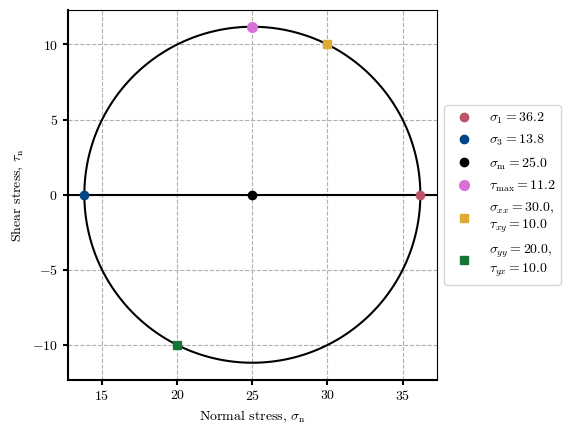

{'sig_1': 36.180339887498945,
 'sig_3': 13.819660112501051,
 'sig_xx': 30,
 'sig_yy': 20,
 'tau_xy': 10,
 's': 25.0,
 't': 11.180339887498947,
 'p': 21.273220037500348,
 'q': 22.360679774997894}

In [4]:
# Imagen no interactiva
plot_mohr_circle(sigma_xx=30, sigma_yy=20, tau_xy=10)

## Herramienta 2: Círculo de tracciones

In [5]:
s, l = {'description_width': '50px'}, wgt.Layout(width='400px')
controls = {
    'sigma_xx': wgt.FloatSlider(value=10, min=-100, max=100, step=.5, description="σ_xx", style=s, layout=l),
    'sigma_yy': wgt.FloatSlider(value=5, min=-100, max=100, step=.5, description="σ_yy", style=s, layout=l),
    'tau_xy': wgt.FloatSlider(value=1, min=-100, max=100, step=.5, description="𝜏_xy", style=s, layout=l),
}
fig = wgt.interactive_output(plot_traction_circle, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))


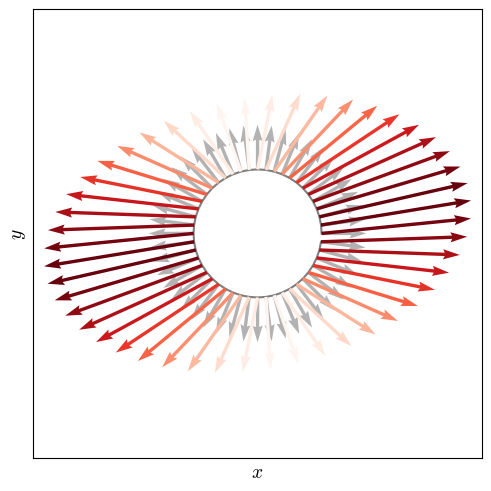

In [6]:
# Imagen no interactiva
plot_traction_circle(sigma_xx=10, sigma_yy=5, tau_xy=1)